In [13]:
%matplotlib inline  
import numpy as np
import GPyOpt
import matplotlib.pyplot as plt

from numpy.random import seed

#### GPyOptのデフォルト機能でコストを考慮したクエリ生成が存在したので、それを用いて実験した
##### acq' = acq/cost
#### コスト関数を評価に係る時間としてみなせば、時間辺りのgreedyなsequentialBOができる

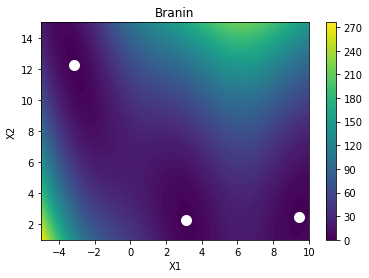

In [2]:
# --- Objective function
objective_true  = GPyOpt.objective_examples.experiments2d.branin()                 # true function
objective_noisy = GPyOpt.objective_examples.experiments2d.branin(sd = 0.1)         # noisy version
bounds = objective_noisy.bounds     
objective_true.plot()

In [3]:
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': bounds[0]}, ## use default bounds
          {'name': 'var_2', 'type': 'continuous', 'domain': bounds[1]}]

In [163]:
# --- Time function with diff
def mycost(x):
    cost_f  = np.atleast_2d(.1*x[:,0]**2 +.1*x[:,1]**2).T +1
    cost_df = np.array([0.2*x[:,0],0.2*x[:,1]]).T
    return cost_f, cost_df

In [140]:
def plotfunc(func):
    # plot the cost fucntion
    grid = 400
    bounds = objective_true.bounds
    X1 = np.linspace(bounds[0][0], bounds[0][1], grid)
    X2 = np.linspace(bounds[1][0], bounds[1][1], grid)
    x1, x2 = np.meshgrid(X1, X2)
    X = np.hstack((x1.reshape(grid*grid,1),x2.reshape(grid*grid,1)))
    cost_X, _ = func(X)
    plt.contourf(X1, X2, cost_X.reshape(grid,grid),100, alpha=1,origin ='lower')
    plt.title('Cost function')
    plt.colorbar()

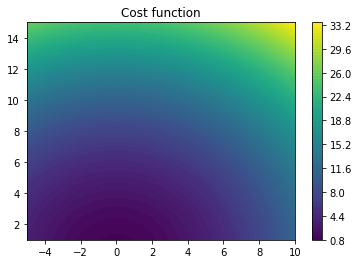

In [164]:
plotfunc(mycost)

In [68]:
seed(12)
BO = GPyOpt.methods.BayesianOptimization(f=objective_noisy.f,  
                                            domain = domain, 
                                            initial_design_numdata = 5,
                                            acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            exact_feval = False,
                                            acquisition_jitter = 0.05)  

In [69]:
seed(12)
BO_cost = GPyOpt.methods.BayesianOptimization(f=objective_noisy.f,  
                                            cost_withGradients = mycost,
                                            initial_design_numdata =5,
                                            domain = domain,                  
                                            acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            exact_feval = False,
                                            acquisition_jitter = 0.05)   

#### Initial Plot

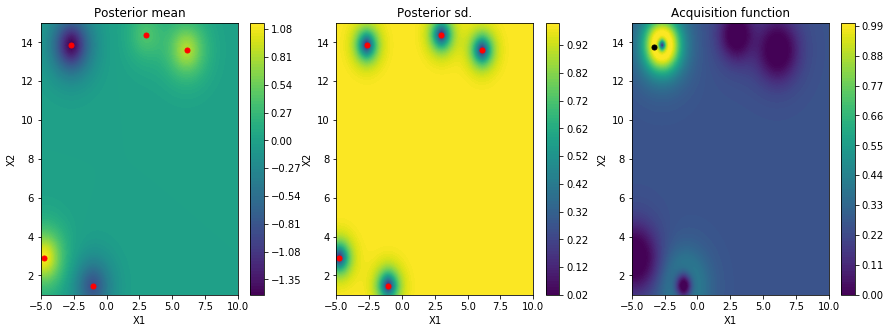

In [70]:
BO.plot_acquisition()

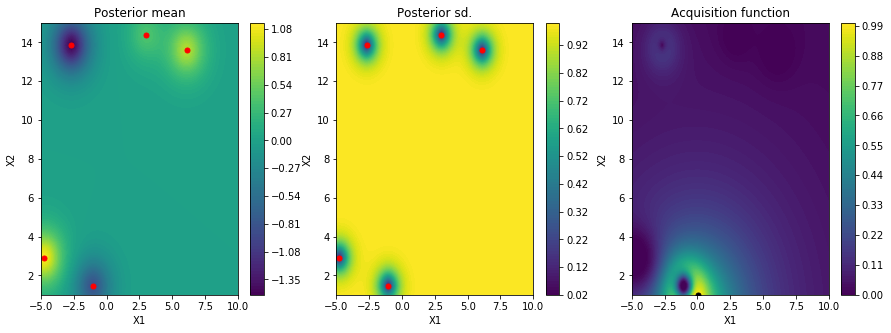

In [71]:
BO_cost.plot_acquisition()

#### After 15 sequential iter

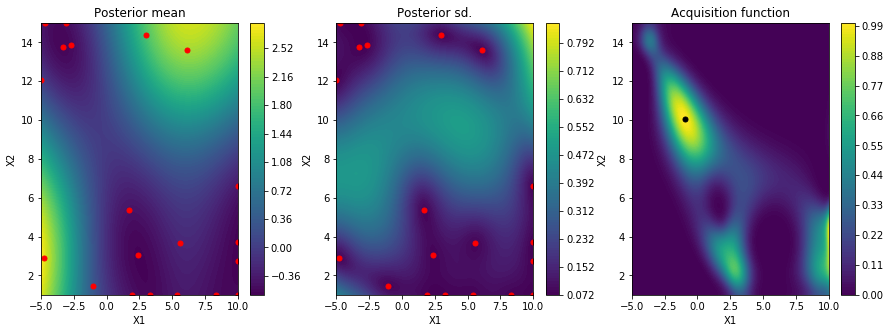

In [72]:
BO.run_optimization(15)
BO.plot_acquisition()

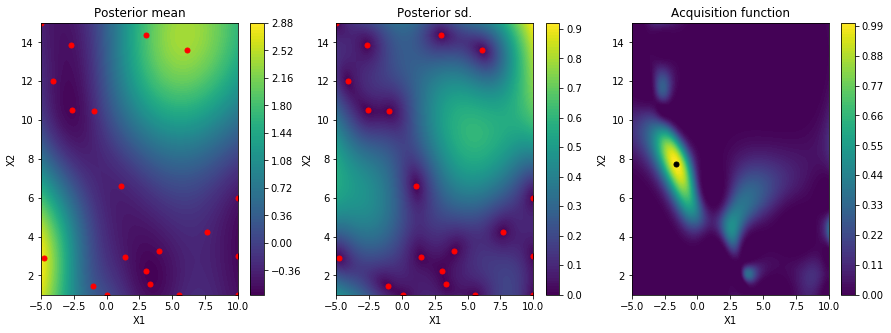

In [73]:
BO_cost.run_optimization(15)
BO_cost.plot_acquisition()

In [74]:
queries_ord = BO.X
queries_time = BO_cost.X
score_ord = BO.Y
score_time = BO_cost.Y

In [75]:
time_ord, _ = mycost(queries_ord)
time_time, _ = mycost(queries_time)

In [98]:
time_ord_sum =np.array(([sum(time_ord[:i+1])[0] for i, val in enumerate(time_ord)]))
time_time_sum =[sum(time_time[:i+1])[0] for i, val in enumerate(time_time)]
score_ord_min =[min(score_ord[:i+1])[0] for i, val in enumerate(score_ord)]
score_time_min =[min(score_time[:i+1])[0] for i, val in enumerate(score_time)]

Text(0,0.5,'bestscore')

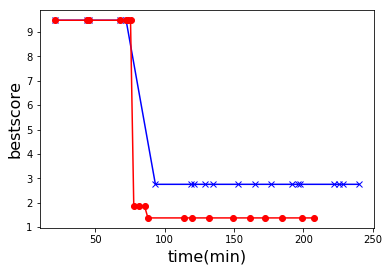

In [100]:
plt.plot(time_ord_sum, score_ord_min,marker = 'x',color="b")
plt.plot(time_time_sum, score_time_min,marker = 'o',color="r")
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)

In [105]:
def run_BO(objective_func, domain, cost_func=None, num_cores=8, max_iter=20, num_init_design=4):
    
    #np.random.seed(123)
    if cost_func == None:
        BO = GPyOpt.methods.BayesianOptimization(f=objective_func,  
                                            domain = domain, 
                                            initial_design_numdata = num_init_design,
                                            acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            exact_feval = False,
                                            acquisition_jitter = 0)
    else:
        BO = GPyOpt.methods.BayesianOptimization(f=objective_func,  
                                            cost_withGradients = cost_func,
                                            initial_design_numdata =num_init_design,
                                            domain = domain,                  
                                            acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            exact_feval = False,
                                            acquisition_jitter = 0)
    
    BO.run_optimization(max_iter)
    #BO_demo_parallel.plot_convergence()
    return BO

In [106]:
def forming(BOobject, cost_func=mycost):
    queries = BOobject.X
    values = BOobject.Y
    time2eval, _ = cost_func(queries)
    time_sum =np.array([sum(time2eval[:i+1])[0] for i, val in enumerate(time2eval)])
    scoremin =np.array([min(values[:i+1])[0] for i, val in enumerate(values)])
    return time_sum, scoremin

## Exp1

In [131]:
# --- Time function with diff
def mycost(x):
    cost_f  = np.atleast_2d(.1*x[:,0]**2 +.1*x[:,1]**2).T +1
    cost_df = np.array([0.2*x[:,0],0.2*x[:,1]]).T
    return cost_f, cost_df

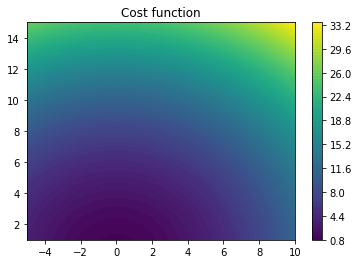

In [165]:
plotfunc(mycost)

In [113]:
n = 5
time_ord_sum = np.array([])
time_time_sum = np.array([])
score_ord_min = np.array([])
score_time_min = np.array([])
for i in range(n):
    BO = run_BO(objective_func=objective_noisy.f, domain = domain)
    BOcost = run_BO(objective_func=objective_noisy.f, cost_func=mycost,domain = domain)
    time, score = forming(BO)
    time_ord_sum = np.append(time_ord_sum, time)
    score_ord_min = np.append(score_ord_min, score)
    time, score = forming(BOcost)
    time_time_sum = np.append(time_time_sum, time)
    score_time_min = np.append(score_time_min, score)
    
time_ord = time_ord_sum.reshape(n,24)
time_time = time_time_sum.reshape(n,24)
score_ord = score_ord_min.reshape(n,24)
score_time = score_time_min.reshape(n,24)

Text(0,0.5,'bestscore')

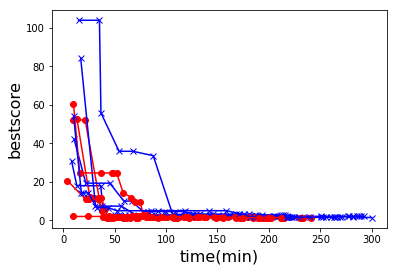

In [116]:
for i in range(n):
    plt.plot(time_ord[i], score_ord[i],marker = 'x',color="b")
    plt.plot(time_time[i], score_time[i],marker = 'o',color="r")
    
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)

Text(0,0.5,'bestscore')

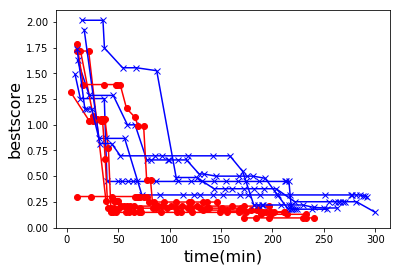

In [117]:
for i in range(n):
    plt.plot(time_ord[i], np.log10(score_ord[i]),marker = 'x',color="b")
    plt.plot(time_time[i], np.log10(score_time[i]),marker = 'o',color="r")
    
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)

## Exp2

In [143]:
def mycost2(x):
    cost_f  = np.atleast_2d(1.*x[:,0] ).T +10
    cost_df = np.array([1,0]).T
    return cost_f, cost_df
func = mycost2

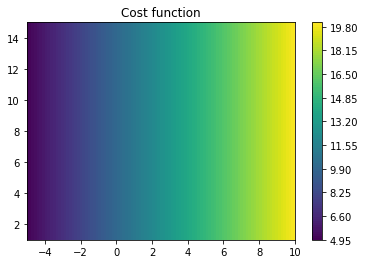

In [144]:
plotfunc(func)

In [129]:
n = 5
time_ord_sum = np.array([])
time_time_sum = np.array([])
score_ord_min = np.array([])
score_time_min = np.array([])
for i in range(n):
    BO = run_BO(objective_func=objective_noisy.f, domain = domain)
    BOcost = run_BO(objective_func=objective_noisy.f, cost_func=mycost2,domain = domain)
    time, score = forming(BO)
    time_ord_sum = np.append(time_ord_sum, time)
    score_ord_min = np.append(score_ord_min, score)
    time, score = forming(BOcost)
    time_time_sum = np.append(time_time_sum, time)
    score_time_min = np.append(score_time_min, score)
    
time_ord = time_ord_sum.reshape(n,24)
time_time = time_time_sum.reshape(n,24)
score_ord = score_ord_min.reshape(n,24)
score_time = score_time_min.reshape(n,24)

Text(0,0.5,'bestscore')

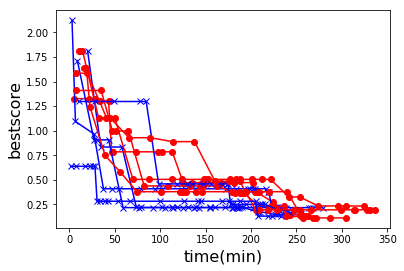

In [130]:
for i in range(n):
    plt.plot(time_ord[i], np.log10(score_ord[i]),marker = 'x',color="b")
    plt.plot(time_time[i], np.log10(score_time[i]),marker = 'o',color="r")
    
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)

## Ex3

In [171]:
def mycost3(x):
    cost_f  = np.atleast_2d(-1.*x[:,0] ).T +13
    cost_df = np.array([-1,0]).T
    return cost_f, cost_df
func = mycost3

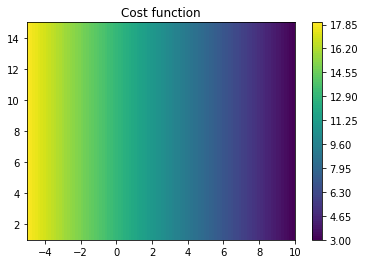

In [172]:
plotfunc(func)

In [138]:
n = 5
time_ord_sum = np.array([])
time_time_sum = np.array([])
score_ord_min = np.array([])
score_time_min = np.array([])
for i in range(n):
    BO = run_BO(objective_func=objective_noisy.f, domain = domain)
    BOcost = run_BO(objective_func=objective_noisy.f, cost_func=func,domain = domain)
    time, score = forming(BO)
    time_ord_sum = np.append(time_ord_sum, time)
    score_ord_min = np.append(score_ord_min, score)
    time, score = forming(BOcost)
    time_time_sum = np.append(time_time_sum, time)
    score_time_min = np.append(score_time_min, score)
    
time_ord = time_ord_sum.reshape(n,24)
time_time = time_time_sum.reshape(n,24)
score_ord = score_ord_min.reshape(n,24)
score_time = score_time_min.reshape(n,24)

Text(0,0.5,'bestscore')

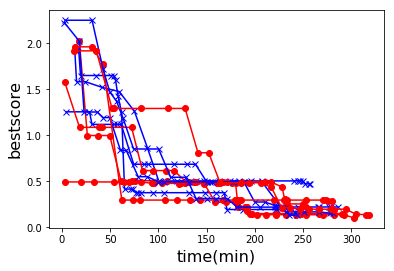

In [139]:
for i in range(n):
    plt.plot(time_ord[i], np.log10(score_ord[i]),marker = 'x',color="b")
    plt.plot(time_time[i], np.log10(score_time[i]),marker = 'o',color="r")
    
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)

## Ex4

In [156]:
def mycost3(x):
    cost_f  = np.atleast_2d(1.*x[:,0]+1.*x[:,1] ).T +9
    #cost_df = np.array([1,1]).T
    cost_df = 0
    return cost_f, cost_df
func = mycost3

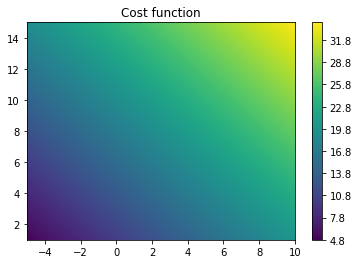

In [157]:
plotfunc(func)

In [158]:
n = 5
time_ord_sum = np.array([])
time_time_sum = np.array([])
score_ord_min = np.array([])
score_time_min = np.array([])
for i in range(n):
    BO = run_BO(objective_func=objective_noisy.f, domain = domain)
    BOcost = run_BO(objective_func=objective_noisy.f, cost_func=func,domain = domain)
    time, score = forming(BO)
    time_ord_sum = np.append(time_ord_sum, time)
    score_ord_min = np.append(score_ord_min, score)
    time, score = forming(BOcost)
    time_time_sum = np.append(time_time_sum, time)
    score_time_min = np.append(score_time_min, score)
    
time_ord = time_ord_sum.reshape(n,24)
time_time = time_time_sum.reshape(n,24)
score_ord = score_ord_min.reshape(n,24)
score_time = score_time_min.reshape(n,24)

Text(0,0.5,'bestscore')

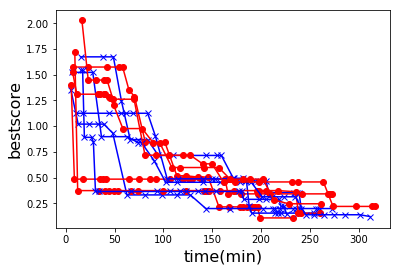

In [159]:
for i in range(n):
    plt.plot(time_ord[i], np.log10(score_ord[i]),marker = 'x',color="b")
    plt.plot(time_time[i], np.log10(score_time[i]),marker = 'o',color="r")
    
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)

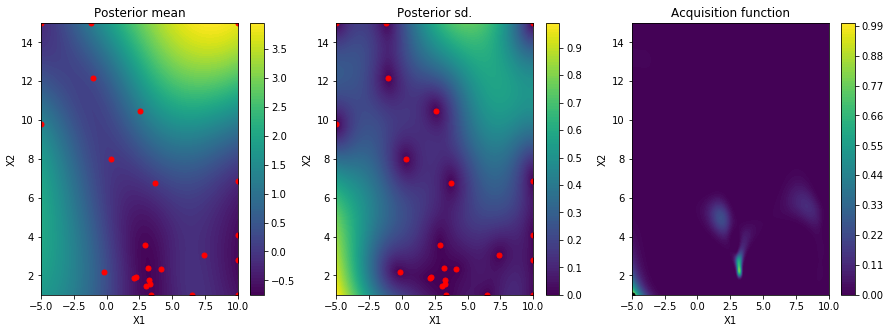

In [162]:
BO.plot_acquisition()

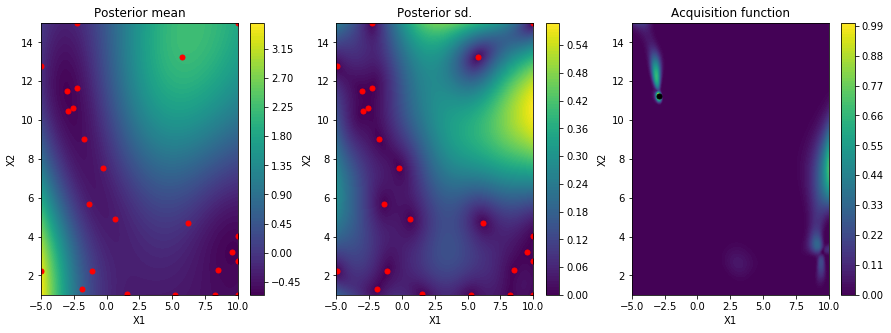

In [161]:
BOcost.plot_acquisition()

## Bestcase

In [175]:
def best(x):
    cost_f  = objective_noisy.f + 10.
    #cost_df = np.array([1,1]).T
    cost_df = 0
    return cost_f, cost_df
func = best

In [176]:
n = 5
time_ord_sum = np.array([])
time_time_sum = np.array([])
score_ord_min = np.array([])
score_time_min = np.array([])
for i in range(n):
    BO = run_BO(objective_func=objective_noisy.f, domain = domain)
    BOcost = run_BO(objective_func=objective_noisy.f, cost_func=func,domain = domain)
    time, score = forming(BO)
    time_ord_sum = np.append(time_ord_sum, time)
    score_ord_min = np.append(score_ord_min, score)
    time, score = forming(BOcost)
    time_time_sum = np.append(time_time_sum, time)
    score_time_min = np.append(score_time_min, score)
    
time_ord = time_ord_sum.reshape(n,24)
time_time = time_time_sum.reshape(n,24)
score_ord = score_ord_min.reshape(n,24)
score_time = score_time_min.reshape(n,24)

TypeError: unsupported operand type(s) for +: 'method' and 'float'

In [ ]:
for i in range(n):
    plt.plot(time_ord[i], np.log10(score_ord[i]),marker = 'x',color="b")
    plt.plot(time_time[i], np.log10(score_time[i]),marker = 'o',color="r")
    
plt.xlabel('time(min)', fontsize = 16)
plt.ylabel('bestscore', fontsize = 16)